In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")
y = pd.read_csv(r"1.1-Output/ProcessedLabels.csv")

In [3]:
X.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [4]:
print(f"Shape of Input Features: {X.shape}")

Shape of Input Features: (2099971, 76)


In [11]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, ReLU

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 20

# Encoder
input_layer = Input(shape=(input_dim,))
x = Dense(64)(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(32, activation='relu')(x)
latent = Dense(encoding_dim, activation='relu', name="latent_space")(x)

# Decoder
x = Dense(32, activation='relu')(latent)
x = Dense(64, activation='relu')(x)
output_layer = Dense(input_dim, activation='sigmoid')(x)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 76)]              0         
                                                                 
 dense (Dense)               (None, 64)                4928      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 latent_space (Dense)        (None, 20)                660       
                                                             

In [13]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7383/7383 [==============================] - 25s 3ms/step - loss: 9.9677e-04 - val_loss: 1.0385e-04
Epoch 2/50
7383/7383 [==============================] - 28s 4ms/step - loss: 7.1973e-05 - val_loss: 4.1189e-05
Epoch 3/50
7383/7383 [==============================] - 33s 4ms/step - loss: 5.4349e-05 - val_loss: 2.5512e-05
Epoch 4/50
7383/7383 [==============================] - 19s 3ms/step - loss: 4.6683e-05 - val_loss: 2.3826e-05
Epoch 5/50
7383/7383 [==============================] - 23s 3ms/step - loss: 4.1724e-05 - val_loss: 2.3332e-05
Epoch 6/50
7383/7383 [==============================] - 37s 5ms/step - loss: 3.8055e-05 - val_loss: 1.6204e-05
Epoch 7/50
7383/7383 [==============================] - 24s 3ms/step - loss: 3.5552e-05 - val_loss: 4.0630e-05
Epoch 8/50
7383/7383 [==============================] - 19s 3ms/step - loss: 3.2743e-05 - val_loss: 1.8500e-05
Epoch 9/50
7383/7383 [==============================] - 24s 3ms/step - loss: 3.0532e-05 - val_loss: 1.6344e-05
E

In [14]:
encoder_model = Model(inputs=autoencoder.input,
                      outputs=autoencoder.get_layer("latent_space").output)

X_encoded = encoder_model.predict(X_scaled)
print("Encoded feature shape:", X_encoded.shape)

X_reconstructed = autoencoder.predict(X_scaled)

65625/65625 [==============================] - 50s 764us/step
Encoded feature shape: (2099971, 20)
65625/65625 [==============================] - 68s 1ms/step


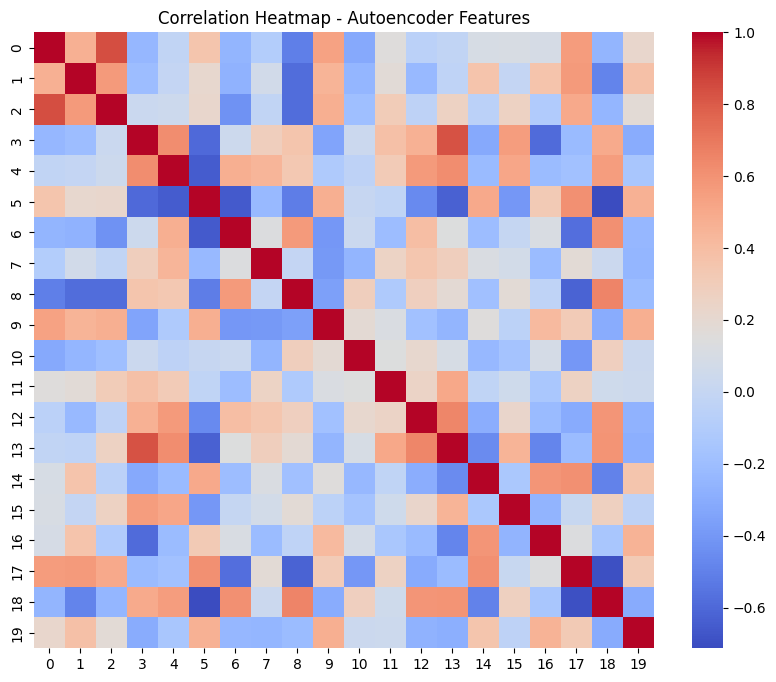

In [15]:
encoded_df = pd.DataFrame(X_encoded)  # assuming X_encoded is ndarray
plt.figure(figsize=(10, 8))
encoded_corr = encoded_df.corr()
sns.heatmap(encoded_corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap - Autoencoder Features")
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

mse_autoencoder = mean_squared_error(X_scaled, X_reconstructed)
print("Autoencoder Reconstruction MSE:", mse_autoencoder)

Autoencoder Reconstruction MSE: 1.4085592185820068e-05


In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_auto = mean_absolute_error(X_scaled, X_reconstructed)
r2_auto = r2_score(X_scaled, X_reconstructed)

print("Autoencoder MAE:", mae_auto, "| R²:", r2_auto)

Autoencoder MAE: 0.0012912525681448767 | R²: 0.8122421894265646
